This notebook display the Gene DB for Prochlorococcus

# Includes and setup

In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
import google.generativeai
import gradio as gr
from IPython.display import Markdown, display, update_display

In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from prompts import * 


In [5]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyCF


# Load list of MED4 genes

In [6]:
med4_genome_dpath = '../genomes/MED4'
#os.listdir(med4_genome_dpath)

In [7]:
gff_named_df = pd.read_csv(os.path.join(med4_genome_dpath, 'MED4_named_genes_NCBI.csv'))
gff_named_df

,gene_name,gene,locus_tag,product,protein_id
0,"dnaN , TX50_RS00020",dnaN,TX50_RS00020,DNA polymerase III subunit beta,WP_011131639.1
1,"purL , TX50_RS00030",purL,TX50_RS00030,phosphoribosylformylglycinamidine synthase sub...,WP_011131641.1
2,"purF , TX50_RS00035",purF,TX50_RS00035,amidophosphoribosyltransferase,WP_011131642.1
3,"queG , TX50_RS00050",queG,TX50_RS00050,tRNA epoxyqueuosine(34) reductase QueG,WP_011131645.1
4,"nusB , TX50_RS00060",nusB,TX50_RS00060,transcription antitermination factor NusB,WP_036930720.1
...,...,...,...,...,...
498,"dnaK , TX50_RS09095",dnaK,TX50_RS09095,molecular chaperone DnaK,WP_011133331.1
499,"rpsF , TX50_RS09105",rpsF,TX50_RS09105,30S ribosomal protein S6,WP_011133333.1
500,"mraY , TX50_RS09125",mraY,TX50_RS09125,phospho-N-acetylmuramoyl-pentapeptide-transferase,WP_036930713.1
501,"uvrA , TX50_RS09140",uvrA,TX50_RS09140,excinuclease ABC subunit UvrA,WP_011133339.1


# Load anthropic batch results

In [8]:
os.listdir('batch results')

['.ipynb_checkpoints',
 'anthropic_batch_single_prompt_26012025_results.jsonl',
 'perplexity_single_structured_prompt_09022025',
 'perplexity_single_structured_prompt_09022025.jsonl']

In [9]:
batch_result_fpath = os.path.join('batch results', 'perplexity_single_structured_prompt_09022025.jsonl')

In [10]:
import jsonlines

In [11]:
with jsonlines.open(batch_result_fpath) as reader:
    batch_results_jsonl = [obj for obj in reader]

In [12]:
def _get_gene_name_from_custom_id(id):
    '''
         extract and return the gene_name from the custom id
         example : 'batch-id-dnaN--TX50_RS00020' --> dnaN, TX50_RS00020
    '''
    #return id.replace('batch-id-', '').replace('--', ' , ')
    id1 = id.replace('batch-id-', '')
    return (id1.split('-')[0])
    #return id.replace('batch-id-', '').replace('--', ' , ')
    

In [21]:
batch_results_jsonl[0]['result']['choices'][0]['message']['content']

'<research_process>\n\n1. Key search terms and databases:\n- Databases: PubMed, Web of Science, Google Scholar\n- Search terms: "Prochlorococcus accB", "Prochlorococcus acetyl-CoA carboxylase", "Prochlorococcus biotin carboxyl carrier protein", "Prochlorococcus fatty acid biosynthesis", "Prochlorococcus lipid metabolism"\n\n2. Overview of available literature:\n- Number of relevant papers: Approximately 15-20 directly relevant papers\n- Date range: 2000-2025\n- Main research focuses: Lipid metabolism in Prochlorococcus, acetyl-CoA carboxylase function, adaptation to nutrient-poor environments\n\n3. Summaries of key sources:\n\n[Biller et al., 2014] Comprehensive review of Prochlorococcus biology. Mentions accB as part of the core genome and its role in fatty acid biosynthesis.\n\n[Kettler et al., 2007] Comparative genomics study of Prochlorococcus strains. Identifies accB as a core gene present in all studied strains.\n\n[Partensky and Garczarek, 2010] Review of Prochlorococcus adaptat

In [16]:
gff_named_df.loc[gff_named_df.gene.isin([_get_gene_name_from_custom_id(batch_results_jsonl[0]['custom_id'])])]

,gene_name,gene,locus_tag,product,protein_id
16,"accB , TX50_RS00150",accB,TX50_RS00150,acetyl-CoA carboxylase biotin carboxyl carrier...,WP_011131665.1


In [52]:
batch_result_dict = {
    _get_gene_name_from_custom_id(m['custom_id']) :  
    {
        'message' : m['result']['choices'][0]['message']['content'], 
        'citations' : m['result']['citations'],
    }
    for m in batch_results_jsonl            
}

In [23]:
batch_results_jsonl[0].keys()

dict_keys(['custom_id', 'result'])

In [24]:
batch_results_jsonl[0]['custom_id']

'batch-id-accB--TX50_RS00150'

In [19]:
# print(batch_results_jsonl[0]['result']['message']['content'][0]['text'])

# Parse the replies into multiple elements

## example

In [26]:
gene = 'dnaN'

In [27]:
text = batch_result_dict[gene]

In [28]:
def parse_claude_message(message):
    tags = {}
    for tag, content in re.findall(r'<(\w+)>(.*?)</\1>', message, re.DOTALL):
        tags[tag] = content.strip()
    return tags

In [29]:
def get_left_text(text, parsed_text):
    left_text = text
    for i in parsed_text: 
        left_text = left_text.replace(parsed_text[i], '')
    return (left_text)
    

In [30]:
def get_inner_tags(text):
    parsed_text = parse_claude_message(text)
    left_text = text
    for i in parsed_text: 
        left_text = left_text.replace(parsed_text[i], '')
    return (left_text)
    

In [53]:

def parse_database_batch_message(gene):
    message = batch_result_dict[gene]['message']
    citations = batch_result_dict[gene]['citations']
    # remove <conservation> tags
    message = message.replace('<conservation>', 'Conservation: ')
    message = message.replace('      Conservation:', '  Conservation:')
    message = message.replace('</conservation>', '')
    # if '</research_process>' not in message:
    #     message = message.replace('<database_entry>', '</research_process>\n\n<database_entry>')
        
    database_section_names = ['primary_function', 'physiological_contribution', 'stress_responses', 'uptake_exudation', 
        'phylogenetic_persistence', 'coculture_role', 'references']
    parsed_text = parse_claude_message(message)
    
    #assert set(parsed_text.keys()) == {'literature_review', 'database_entry'}, f'Wrong top keys: {parsed_text.keys()}, gene: {gene}'
    assert 'database_entry' in parsed_text.keys() , f'Missing database_entry. Wrong top keys: {parsed_text.keys()}, gene: {gene}'
    if 'research_process' in parsed_text.keys():
        literature_review = parsed_text['research_process']
    else:
        literature_review = ''
        print(f'Missing literature_review ({gene})')
        
    database_entry = parsed_text['database_entry']
    parsed_database_entry = parse_claude_message(database_entry)
    assert set(list(parsed_database_entry.keys())) == set(database_section_names), f'Wrong database section names: {parsed_database_entry.keys()}, gene: {gene}' 
    for i in ['stress_responses', 'uptake_exudation', 'references']:
        parsed_database_entry[i] = parse_claude_message(parsed_database_entry[i])
    parsed_database_entry['citations'] = citations
    return literature_review, parsed_database_entry
    #print(parsed_database_entry)
    # for i in database_sections:
    #     print(i)
    #     print(get_inner_tags(parsed_database_entry[i]))
    
 

In [54]:
literature_review, database_entry = parse_database_batch_message(gene)

In [59]:
def database_section_dict2text(section_dict):
    items_list = [f'* {name}: {text}' for name, text in section_dict.items()]
    return '\n\n'.join(items_list)

def database_section_list2text(section_dict):
    items_list = [f'* {text}' for  text in section_dict]
    return '\n\n'.join(items_list)

def database_section2text(section_name, section_content):
    if isinstance(section_content, dict):
        section_content = database_section_dict2text(section_content)
    if isinstance(section_content, list):
        section_content = database_section_list2text(section_content)
    section_name = section_name.capitalize()
    return f'\n### {section_name}\n\n{section_content}\n'

In [60]:
def database_entry2text(database_entry):
    title = '# Database Entry\n'
    return title + '\n'.join([database_section2text(section_name, section_content) for section_name, section_content in database_entry.items()])


In [61]:
def literature_review2text(literature_review):
    lines = literature_review.split('\n')
    new_lines = [f'### {line}\n' if line and line[0].isdigit() else line for line in lines]
    title = '# Literature Review\n'
    return title + '\n'.join(new_lines)


In [45]:
display(Markdown(literature_review2text(literature_review)))


# Literature Review
### 1. Key search terms and databases:

- Databases: PubMed, Web of Science, Google Scholar
- Search terms: "Prochlorococcus dnaN", "Prochlorococcus DNA polymerase III subunit beta", "Prochlorococcus DNA replication", "Prochlorococcus genome replication", "Prochlorococcus WP_011131639.1"

### 2. Overview of available literature:

- Number of relevant papers: Approximately 15-20 papers directly related to dnaN in Prochlorococcus
- Date range: 2003-2025
- Main research focuses: DNA replication in Prochlorococcus, comparative genomics of marine cyanobacteria, stress responses in Prochlorococcus

### 3. Summaries of key sources:


a) Kettler et al. (2007) PLoS Genetics
Citation: Kettler, G. C., Martiny, A. C., Huang, K., Zucker, J., Coleman, M. L., Rodrigue, S., ... & Chisholm, S. W. (2007). Patterns and implications of gene gain and loss in the evolution of Prochlorococcus. PLoS genetics, 3(12), e231.
Summary: Identified dnaN as part of the core genome of Prochlorococcus, present in all 12 sequenced strains. Suggests its essential role in DNA replication across all Prochlorococcus ecotypes.

b) Biller et al. (2014) Nature Reviews Microbiology
Citation: Biller, S. J., Berube, P. M., Lindell, D., & Chisholm, S. W. (2015). Prochlorococcus: the structure and function of collective diversity. Nature Reviews Microbiology, 13(1), 13-27.
Summary: Discusses the importance of DNA replication genes, including dnaN, in the context of Prochlorococcus' streamlined genome and rapid cell division rates in oligotrophic environments.

c) Partensky and Garczarek (2010) Annual Review of Marine Science
Citation: Partensky, F., & Garczarek, L. (2010). Prochlorococcus: advantages and limits of minimalism. Annual review of marine science, 2, 305-331.
Summary: Highlights the conservation of essential DNA replication genes like dnaN across Prochlorococcus strains, despite overall genome reduction trends in this genus.

d) Osburne et al. (2010) Environmental Microbiology
Citation: Osburne, M. S., Holmbeck, B. M., Frias-Lopez, J., Steen, R., Huang, K., Kelly, L., ... & Chisholm, S. W. (2010). UV hyper-resistance in Prochlorococcus MED4 results from a single base pair deletion just upstream of an operon encoding nudix hydrolase and photolyase. Environmental microbiology, 12(7), 1978-1988.
Summary: While not directly focused on dnaN, this study provides insights into DNA repair mechanisms in Prochlorococcus, which are closely linked to DNA replication processes.

e) Biller et al. (2016) mSystems
Citation: Biller, S. J., Coe, A., & Chisholm, S. W. (2016). Torn apart and reunited: impact of a heterotroph on the transcriptome of Prochlorococcus. mSystems, 1(3), e00055-16.
Summary: Examines gene expression changes in Prochlorococcus when co-cultured with heterotrophic bacteria. While not specifically mentioning dnaN, it provides context for understanding gene regulation in different growth conditions.

### 4. Challenges or limitations:

- Limited studies focusing specifically on dnaN in Prochlorococcus
- Most information is derived from broader genomic or transcriptomic studies
- Lack of detailed biochemical characterization of the DnaN protein in Prochlorococcus

### 5. Conflicting information or gaps:

- Limited information on the specific regulation of dnaN expression in Prochlorococcus
- Lack of studies on potential post-translational modifications of DnaN in Prochlorococcus
- Limited understanding of how dnaN expression might change under various stress conditions

### 6. Initial observations:

- dnaN appears to be an essential gene in Prochlorococcus, conserved across all known strains
- Its function is likely similar to that in other bacteria, playing a crucial role in DNA replication
- The gene's conservation despite genome streamlining suggests its critical importance for Prochlorococcus survival

### 7. Key themes and patterns:

- Conservation of essential DNA replication machinery across Prochlorococcus strains
- Importance of efficient DNA replication in the context of rapid cell division in oligotrophic environments
- Potential links between DNA replication and repair mechanisms in Prochlorococcus

### 8. Potential implications:

- The conservation of dnaN across Prochlorococcus strains might indicate its potential as a marker for studying population dynamics and evolution in marine environments
- Understanding dnaN regulation could provide insights into how Prochlorococcus maintains genomic stability in high-light, high-UV marine environments
- Comparative studies of dnaN across different Prochlorococcus ecotypes might reveal adaptations in DNA replication efficiency related to different environmental niches

In [46]:
database_entry

{'primary_function': 'The dnaN gene in Prochlorococcus encodes the beta subunit of DNA polymerase III, which is the primary enzyme complex responsible for DNA replication in bacteria. This subunit functions as the sliding clamp, encircling the DNA and tethering the polymerase to the template, thereby greatly enhancing the processivity of DNA synthesis [Biller et al., 2015].\n    Conservation: This function appears to be highly conserved across all known Prochlorococcus strains and is likely similar to its role in other bacteria, given its presence in the core genome of Prochlorococcus [Kettler et al., 2007].',
 'physiological_contribution': "The DnaN protein plays a crucial role in enabling the rapid and efficient DNA replication necessary for Prochlorococcus' characteristically fast growth rates in oligotrophic environments. Its function is essential for maintaining genomic integrity during cell division, which occurs up to once per day in optimal conditions [Partensky and Garczarek, 

In [62]:
display(Markdown(database_entry2text(database_entry)))

# Database Entry

### Primary_function

The dnaN gene in Prochlorococcus encodes the beta subunit of DNA polymerase III, which is the primary enzyme complex responsible for DNA replication in bacteria. This subunit functions as the sliding clamp, encircling the DNA and tethering the polymerase to the template, thereby greatly enhancing the processivity of DNA synthesis [Biller et al., 2015].
    Conservation: This function appears to be highly conserved across all known Prochlorococcus strains and is likely similar to its role in other bacteria, given its presence in the core genome of Prochlorococcus [Kettler et al., 2007].


### Physiological_contribution

The DnaN protein plays a crucial role in enabling the rapid and efficient DNA replication necessary for Prochlorococcus' characteristically fast growth rates in oligotrophic environments. Its function is essential for maintaining genomic integrity during cell division, which occurs up to once per day in optimal conditions [Partensky and Garczarek, 2010].
    Conservation: This physiological contribution is likely conserved across all Prochlorococcus ecotypes, as efficient DNA replication is critical for survival and competitiveness in their marine habitats [Biller et al., 2015].


### Stress_responses

* response1: While not directly studied for dnaN, DNA replication in Prochlorococcus is likely affected by UV stress, a common challenge in the surface waters of oligotrophic oceans. The efficient function of DnaN may be crucial in maintaining replication fidelity under these conditions [Osburne et al., 2010].
  Conservation: This response is likely conserved, especially in high-light ecotypes of Prochlorococcus that inhabit surface waters, but may vary in its extent across different ecotypes [Partensky and Garczarek, 2010].

* response2: Nutrient limitation, particularly phosphorus scarcity, may impact DNA replication processes. While not specifically studied for dnaN, the overall DNA replication machinery, including DnaN, might be affected under such stress conditions [Biller et al., 2015].
  Conservation: This response is likely conserved across Prochlorococcus strains, given the widespread occurrence of nutrient limitation in their habitats, but the specific mechanisms may vary [Biller et al., 2015].


### Uptake_exudation

* uptake: There is no direct evidence of DnaN being involved in uptake processes in Prochlorococcus.
  Conservation: Not applicable due to lack of evidence.

* exudation: There is no direct evidence of DnaN being involved in exudation processes in Prochlorococcus.
  Conservation: Not applicable due to lack of evidence.


### Phylogenetic_persistence

The dnaN gene is part of the core genome of Prochlorococcus, present in all sequenced strains [Kettler et al., 2007]. Its sequence is highly conserved across different Prochlorococcus ecotypes, reflecting its essential function. The gene is also found in other marine cyanobacteria like Synechococcus, suggesting a broader conservation across marine picocyanobacteria [Biller et al., 2015].


### Coculture_role

There is no specific information available about changes in dnaN expression or function when Prochlorococcus is in coculture with heterotrophic bacteria. However, given its essential role in DNA replication, it's likely that dnaN expression remains relatively stable even under coculture conditions [Biller et al., 2016].
    Conservation: The conservation of dnaN expression in coculture conditions is not well-studied, but given its essential function, it's likely to be maintained across different coculture scenarios.


### References

* ref1: Kettler, G. C., Martiny, A. C., Huang, K., Zucker, J., Coleman, M. L., Rodrigue, S., ... & Chisholm, S. W. (2007). Patterns and implications of gene gain and loss in the evolution of Prochlorococcus. PLoS genetics, 3(12), e231.

* ref2: Biller, S. J., Berube, P. M., Lindell, D., & Chisholm, S. W. (2015). Prochlorococcus: the structure and function of collective diversity. Nature Reviews Microbiology, 13(1), 13-27.

* ref3: Partensky, F., & Garczarek, L. (2010). Prochlorococcus: advantages and limits of minimalism. Annual review of marine science, 2, 305-331.

* ref4: Osburne, M. S., Holmbeck, B. M., Frias-Lopez, J., Steen, R., Huang, K., Kelly, L., ... & Chisholm, S. W. (2010). UV hyper-resistance in Prochlorococcus MED4 results from a single base pair deletion just upstream of an operon encoding nudix hydrolase and photolyase. Environmental microbiology, 12(7), 1978-1988.

* ref5: Biller, S. J., Coe, A., & Chisholm, S. W. (2016). Torn apart and reunited: impact of a heterotroph on the transcriptome of Prochlorococcus. mSystems, 1(3), e00055-16.


### Citations

* https://journals.plos.org/plosbiology/article?id=10.1371%2Fjournal.pbio.0030144

* https://academic.oup.com/nar/article/42/3/1393/1062885?login=false

* https://eprints.soton.ac.uk/436684/1/Carter_Gates_Michael_PhD_Thesis_Dec_2019.pdf

* https://en.wikipedia.org/wiki/Prochlorococcus

* https://www.uniprot.org/uniprotkb/A0AAC9LZX9/entry

* https://www.researchgate.net/publication/268987175_Prochlorococcus_The_structure_and_function_of_collective_diversity

* https://website.whoi.edu/gfd/wp-content/uploads/sites/14/2018/10/2015Biller_NatRevMicro_263124.pdf

* https://www.genome.jp/brite/pmm00001+PMM0200

* https://www.science.org/doi/10.1126/sciadv.adp1949

* https://www.pnas.org/doi/10.1073/pnas.2025638118


# Build Gene DB

In [98]:
def database_section2list(section_name, section_content):
    if isinstance(section_content, dict):
        if section_name == 'uptake_exudation':
            return (section_content.items())
        else:
            return ((section_name, v) for v in section_content.values())
    elif isinstance(section_content, list):
        return ((section_name, v) for v in section_content)
    else: 
        return [(section_name, section_content)]

def get_database_entry_df(gene):
    literature_review, database_entry = parse_database_batch_message(gene)
    content_list = [
        dict(gene=gene, section_name=name, section_content=content) 
        for section_name, section_content in database_entry.items()
        for name,content in database_section2list(section_name, section_content)
    ]
    return pd.DataFrame(content_list)


In [99]:
get_database_entry_df(gene)

,gene,section_name,section_content
0,dnaN,primary_function,The dnaN gene in Prochlorococcus encodes the b...
1,dnaN,physiological_contribution,The DnaN protein plays a crucial role in enabl...
2,dnaN,stress_responses,"While not directly studied for dnaN, DNA repli..."
3,dnaN,stress_responses,"Nutrient limitation, particularly phosphorus s..."
4,dnaN,uptake,There is no direct evidence of DnaN being invo...
5,dnaN,exudation,There is no direct evidence of DnaN being invo...
6,dnaN,phylogenetic_persistence,The dnaN gene is part of the core genome of Pr...
7,dnaN,coculture_role,There is no specific information available abo...
8,dnaN,references,"Kettler, G. C., Martiny, A. C., Huang, K., Zuc..."
9,dnaN,references,"Biller, S. J., Berube, P. M., Lindell, D., & C..."


In [100]:

df_database = pd.concat([get_database_entry_df(gene) for gene in batch_result_dict], ignore_index=True)


In [101]:
df_database['citations'] = df_database['section_content'].str.findall(r'(\[[^\]]+\])').str.join(', ')

In [102]:
df_database[['section_content', 'Conservation']] = df_database.section_content.str.split('Conservation: ', expand=True)

In [103]:
df_database.head(10)

,gene,section_name,section_content,citations,Conservation
0,accB,primary_function,The accB gene in Prochlorococcus encodes the b...,"[Biller et al., 2014], [Cronan and Waldrop, 20...",The accB gene appears to be highly conserved a...
1,accB,physiological_contribution,AccB contributes significantly to Prochlorococ...,"[Partensky and Garczarek, 2010], [Kettler et a...",This contribution to cellular physiology appea...
2,accB,stress_responses,While specific data on accB-related stress res...,"[Partensky and Garczarek, 2010]",This response is likely conserved across Proch...
3,accB,stress_responses,AccB may play a role in temperature stress res...,,The conservation of this response across Proch...
4,accB,uptake,There is no direct evidence of AccB involvemen...,"[Schirmer et al., 2016]",The indirect influence on uptake processes is ...
5,accB,exudation,No specific information is available on AccB's...,,Conservation of exudation processes related to...
6,accB,phylogenetic_persistence,The accB gene shows high phylogenetic persiste...,"[Kettler et al., 2007], [Cronan and Waldrop, 2...",None
7,accB,coculture_role,Specific information about accB expression cha...,,The conservation of coculture-specific roles c...
8,accB,references,"Biller, S. J., Berube, P. M., Lindell, D., & C...",,None
9,accB,references,"Kettler, G. C., Martiny, A. C., Huang, K., Zuc...",,None


# References

In [104]:
reference_df = df_database.loc[df_database.section_name.isin(['references']), ['gene','section_content']]

In [105]:
ref_pattern_missing_comma = r'^([^\d\(]+) \(?(\d+)\)?\.? ([^\.]+)\. (.*)$'
reference_df[['Authors', 'Year', 'Title', 'Journal_pages']] = reference_df['section_content'].str.replace('sp. strain', 'sp strain', regex=False).str.extract(ref_pattern_missing_comma)
reference_df[['Journal', 'Pages']] = reference_df['Journal_pages'].str.extract(r'([^\d,]+),? (.*)')
reference_df[['First Author']] = reference_df['Authors'].str.extract(r'^(\w+)')


In [106]:
for col in reference_df.columns:
    reference_df[col] = reference_df[col].str.strip()
reference_df['First Author lower'] = reference_df['First Author'].str.lower()
reference_df['Title lower'] = reference_df['Title'].str.lower()

In [107]:
reference_df = reference_df.reset_index(drop=True)


In [108]:
reference_df

,gene,section_content,Authors,Year,Title,Journal_pages,Journal,Pages,First Author,First Author lower,Title lower
0,accB,"Biller, S. J., Berube, P. M., Lindell, D., & C...","Biller, S. J., Berube, P. M., Lindell, D., & C...",2014,Prochlorococcus: the structure and function of...,"Nature Reviews Microbiology, 12(7), 472-484.",Nature Reviews Microbiology,"12(7), 472-484.",Biller,biller,prochlorococcus: the structure and function of...
1,accB,"Kettler, G. C., Martiny, A. C., Huang, K., Zuc...","Kettler, G. C., Martiny, A. C., Huang, K., Zuc...",2007,Patterns and implications of gene gain and los...,"PLoS genetics, 3(12), e231.",PLoS genetics,"3(12), e231.",Kettler,kettler,patterns and implications of gene gain and los...
2,accB,"Partensky, F., & Garczarek, L. (2010). Prochlo...","Partensky, F., & Garczarek, L.",2010,Prochlorococcus: advantages and limits of mini...,"Annual review of marine science, 2, 305-331.",Annual review of marine science,"2, 305-331.",Partensky,partensky,prochlorococcus: advantages and limits of mini...
3,accB,"Zubkov, M. V., Fuchs, B. M., Tarran, G. A., Bu...","Zubkov, M. V., Fuchs, B. M., Tarran, G. A., Bu...",2003,High rate of uptake of organic nitrogen compou...,"Applied and Environmental Microbiology, 69(2),...",Applied and Environmental Microbiology,"69(2), 1299-1304.",Zubkov,zubkov,high rate of uptake of organic nitrogen compou...
4,accB,"Schirmer, A., Rude, M. A., Li, X., Popova, E.,...","Schirmer, A., Rude, M. A., Li, X., Popova, E.,...",2016,Microbial biosynthesis of alkanes,"Science, 329(5991), 559-562.",Science,"329(5991), 559-562.",Schirmer,schirmer,microbial biosynthesis of alkanes
...,...,...,...,...,...,...,...,...,...,...,...
1891,zwf,"Carter, M. G. (2019). Transcriptional Mechanis...","Carter, M. G.",2019,Transcriptional Mechanisms of Thermal Acclimat...,University of Southampton.,University of,Southampton.,Carter,carter,transcriptional mechanisms of thermal acclimat...
1892,zwf,"Gómez-Baena, G., López-Lozano, A., Gil-Martíne...","Gómez-Baena, G., López-Lozano, A., Gil-Martíne...",2008,Glucose uptake and its effect on gene expressi...,"PLoS One, 3(10), e3416.",PLoS One,"3(10), e3416.",Gómez,gómez,glucose uptake and its effect on gene expressi...
1893,zwf,"Mella-Flores, D., Six, C., Ratin, M., Partensk...","Mella-Flores, D., Six, C., Ratin, M., Partensk...",2012,Prochlorococcus and Synechococcus have evolved...,"Frontiers in microbiology, 3, 285.",Frontiers in microbiology,"3, 285.",Mella,mella,prochlorococcus and synechococcus have evolved...
1894,zwf,"Scanlan, D. J., Ostrowski, M., Mazard, S., Duf...","Scanlan, D. J., Ostrowski, M., Mazard, S., Duf...",2009,Ecological genomics of marine picocyanobacteria,"Microbiology and Molecular Biology Reviews, 73...",Microbiology and Molecular Biology Reviews,"73(2), 249-299.",Scanlan,scanlan,ecological genomics of marine picocyanobacteria


In [109]:
reference_list = reference_df.section_content.to_list()
with open("reference_list_try1_perplexity_1.txt", "w", encoding="utf-8") as file:
    file.write('\n'.join([f'{i}. {v}\n' for i,v in enumerate(reference_list[:900], start=1)]))
with open("reference_list_try1_perplexity_2.txt", "w", encoding="utf-8") as file:
    file.write('\n'.join([f'{i}. {v}\n' for i,v in enumerate(reference_list[900:], start=1)]))


In [110]:
len(reference_list)

1896

In [75]:
reference_df.nunique()

gene                  363
section_content       965
Authors               722
Year                   38
Title                 620
Journal_pages         750
Journal               236
Pages                 707
First Author          393
First Author lower    393
Title lower           601
dtype: int64

In [76]:
reference_df

,gene,section_content,Authors,Year,Title,Journal_pages,Journal,Pages,First Author,First Author lower,Title lower
0,accB,"Biller, S. J., Berube, P. M., Lindell, D., & C...","Biller, S. J., Berube, P. M., Lindell, D., & C...",2014,Prochlorococcus: the structure and function of...,"Nature Reviews Microbiology, 12(7), 472-484.",Nature Reviews Microbiology,"12(7), 472-484.",Biller,biller,prochlorococcus: the structure and function of...
1,accB,"Kettler, G. C., Martiny, A. C., Huang, K., Zuc...","Kettler, G. C., Martiny, A. C., Huang, K., Zuc...",2007,Patterns and implications of gene gain and los...,"PLoS genetics, 3(12), e231.",PLoS genetics,"3(12), e231.",Kettler,kettler,patterns and implications of gene gain and los...
2,accB,"Partensky, F., & Garczarek, L. (2010). Prochlo...","Partensky, F., & Garczarek, L.",2010,Prochlorococcus: advantages and limits of mini...,"Annual review of marine science, 2, 305-331.",Annual review of marine science,"2, 305-331.",Partensky,partensky,prochlorococcus: advantages and limits of mini...
3,accB,"Zubkov, M. V., Fuchs, B. M., Tarran, G. A., Bu...","Zubkov, M. V., Fuchs, B. M., Tarran, G. A., Bu...",2003,High rate of uptake of organic nitrogen compou...,"Applied and Environmental Microbiology, 69(2),...",Applied and Environmental Microbiology,"69(2), 1299-1304.",Zubkov,zubkov,high rate of uptake of organic nitrogen compou...
4,accB,"Schirmer, A., Rude, M. A., Li, X., Popova, E.,...","Schirmer, A., Rude, M. A., Li, X., Popova, E.,...",2016,Microbial biosynthesis of alkanes,"Science, 329(5991), 559-562.",Science,"329(5991), 559-562.",Schirmer,schirmer,microbial biosynthesis of alkanes
...,...,...,...,...,...,...,...,...,...,...,...
1891,zwf,"Carter, M. G. (2019). Transcriptional Mechanis...","Carter, M. G.",2019,Transcriptional Mechanisms of Thermal Acclimat...,University of Southampton.,University of,Southampton.,Carter,carter,transcriptional mechanisms of thermal acclimat...
1892,zwf,"Gómez-Baena, G., López-Lozano, A., Gil-Martíne...","Gómez-Baena, G., López-Lozano, A., Gil-Martíne...",2008,Glucose uptake and its effect on gene expressi...,"PLoS One, 3(10), e3416.",PLoS One,"3(10), e3416.",Gómez,gómez,glucose uptake and its effect on gene expressi...
1893,zwf,"Mella-Flores, D., Six, C., Ratin, M., Partensk...","Mella-Flores, D., Six, C., Ratin, M., Partensk...",2012,Prochlorococcus and Synechococcus have evolved...,"Frontiers in microbiology, 3, 285.",Frontiers in microbiology,"3, 285.",Mella,mella,prochlorococcus and synechococcus have evolved...
1894,zwf,"Scanlan, D. J., Ostrowski, M., Mazard, S., Duf...","Scanlan, D. J., Ostrowski, M., Mazard, S., Duf...",2009,Ecological genomics of marine picocyanobacteria,"Microbiology and Molecular Biology Reviews, 73...",Microbiology and Molecular Biology Reviews,"73(2), 249-299.",Scanlan,scanlan,ecological genomics of marine picocyanobacteria


In [78]:
#reference_df = reference_df.sort_values(by='crossref DOI')

In [79]:
reference_df.loc[reference_df.section_content.str.contains('strain')] #.section_content.unique()

,gene,section_content,Authors,Year,Title,Journal_pages,Journal,Pages,First Author,First Author lower,Title lower
33,amt,"Lindell D, et al. (2002) Nitrogen stress respo...","Lindell D, et al.",2002,Nitrogen stress response of Prochlorococcus st...,J Phycol 38:1113-1124.,J Phycol,38:1113-1124.,Lindell,lindell,nitrogen stress response of prochlorococcus st...
91,aroB,"Aharonovich, D., & Sher, D. (2016). Transcript...","Aharonovich, D., & Sher, D.",2016,Transcriptional response of Prochlorococcus to...,"The ISME journal, 10(12), 2892-2906.",The ISME journal,"10(12), 2892-2906.",Aharonovich,aharonovich,transcriptional response of prochlorococcus to...
96,aroC,"Aharonovich, D., & Sher, D. (2016). Transcript...","Aharonovich, D., & Sher, D.",2016,Transcriptional response of Prochlorococcus to...,"The ISME journal, 10(12), 2892-2906.",The ISME journal,"10(12), 2892-2906.",Aharonovich,aharonovich,transcriptional response of prochlorococcus to...
101,aroH,"Aharonovich, D., & Sher, D. (2016). Transcript...","Aharonovich, D., & Sher, D.",2016,Transcriptional response of Prochlorococcus to...,"The ISME journal, 10(12), 2892-2906.",The ISME journal,"10(12), 2892-2906.",Aharonovich,aharonovich,transcriptional response of prochlorococcus to...
107,arsB,"López-Maury, L., Florencio, F. J., & Reyes, J....","López-Maury, L., Florencio, F. J., & Reyes, J. C.",2003,Arsenic sensing and resistance system in the c...,"Journal of Bacteriology, 185(18), 5363-5371.",Journal of Bacteriology,"185(18), 5363-5371.",López,lópez,arsenic sensing and resistance system in the c...
140,bcp,"Hosoya-Matsuda, N., Motohashi, K., Yoshimura, ...","Hosoya-Matsuda, N., Motohashi, K., Yoshimura, ...",2005,Anti-oxidative stress system in cyanobacteria:...,"Journal of Biological Chemistry, 280(1), 840-846.",Journal of Biological Chemistry,"280(1), 840-846.",Hosoya,hosoya,anti-oxidative stress system in cyanobacteria:...
185,chlG,"Aharonovich, D., & Sher, D. (2016). Transcript...","Aharonovich, D., & Sher, D.",2016,Transcriptional response of Prochlorococcus to...,"The ISME Journal, 10(12), 2892-2906.",The ISME Journal,"10(12), 2892-2906.",Aharonovich,aharonovich,transcriptional response of prochlorococcus to...
210,coaD,"Aharonovich, D., & Sher, D. (2016). Transcript...","Aharonovich, D., & Sher, D.",2016,Transcriptional response of Prochlorococcus to...,"The ISME journal, 10(12), 2892-2906.",The ISME journal,"10(12), 2892-2906.",Aharonovich,aharonovich,transcriptional response of prochlorococcus to...
236,coxB,"Thompson, A.W., Huang, K., Saito, M.A. and Chi...","Thompson, A.W., Huang, K., Saito, M.A. and Chi...",2011,Transcriptome response of high-and low-light-a...,"The ISME journal, 5(10), pp.1580-1594.",The ISME journal,"5(10), pp.1580-1594.",Thompson,thompson,transcriptome response of high-and low-light-a...
245,crtH,"Zhu, Y., Graham, J. E., Ludwig, M., Xiong, W.,...","Zhu, Y., Graham, J. E., Ludwig, M., Xiong, W.,...",2010,Roles of xanthophyll carotenoids in protection...,"Archives of Biochemistry and Biophysics, 504(1...",Archives of Biochemistry and Biophysics,"504(1), 86-99.",Zhu,zhu,roles of xanthophyll carotenoids in protection...


In [80]:
#.sort_values(by='crossref DOI')
number_of_references_df = reference_df.groupby(
    ['First Author lower','Year', 'Title lower'], #dropna=False   
).apply(
    lambda x: x.head(1).assign(Number_of_Genes=len(x), #DOI=','.join(x['crossref DOI'].dropna().unique()),
                              ), include_groups=False
).reset_index(drop=False).sort_values(by='Number_of_Genes', ascending=False)

number_of_references_df = number_of_references_df[['First Author', 'Year', 'Title', #'DOI', 
                                                   'Number_of_Genes', 'gene', 
       'Authors', 'Journal', 'Pages', 'section_content',]]
number_of_references_df = number_of_references_df.rename(columns= {
    'gene' : 'Example gene', 
    'Authors' : 'Example Authors', 
    'Journal' : 'Example Journal', 
    'Pages' : 'Example Pages', 
    'section_content' : 'Example full reference', 
})


In [81]:
number_of_references_df.columns

Index(['First Author', 'Year', 'Title', 'Number_of_Genes', 'Example gene',
       'Example Authors', 'Example Journal', 'Example Pages',
       'Example full reference'],
      dtype='object')

tmpdf = number_of_references_df.loc[number_of_references_df.DOI.isin([''])].copy().reset_index(drop=True)
with open("reference_list_try1_3.txt", "w", encoding="utf-8") as file:
    reference_list = tmpdf['Example Authors'] + ' (' + tmpdf['Year'] + ') ' + tmpdf['Title'].to_list()
    file.write('\n'.join([f'{i}. {v}\n' for i,v in enumerate(reference_list, start=1)]))


In [82]:
number_of_references_df.columns, reference_df.columns

(Index(['First Author', 'Year', 'Title', 'Number_of_Genes', 'Example gene',
        'Example Authors', 'Example Journal', 'Example Pages',
        'Example full reference'],
       dtype='object'),
 Index(['gene', 'section_content', 'Authors', 'Year', 'Title', 'Journal_pages',
        'Journal', 'Pages', 'First Author', 'First Author lower',
        'Title lower'],
       dtype='object'))

In [83]:
tmpdf = reference_df.loc[reference_df.Title.isna()].rename(columns={
     'gene' : 'Example gene', 'section_content' : 'Example full reference', 'Authors': 'Example Authors', 
    'Journal' : 'Example Journal', 'Pages' : 'Example Pages', 
         #'crossref DOI' : 'DOI'
})
tmpdf['Number_of_Genes'] = 1

number_of_references_df = pd.concat([number_of_references_df,tmpdf[number_of_references_df.columns] ], ignore_index=True)

In [84]:
number_of_references_df = number_of_references_df.sort_values(by=['Number_of_Genes', #'DOI'
                                                                 ], ascending=False)


In [85]:
number_of_references_df.shape, #number_of_references_df.DOI.nunique(), reference_df['crossref DOI'].nunique()


((713, 9),)

In [65]:
reference_df.loc[~reference_df['crossref DOI'].isna() & ~reference_df['crossref DOI'].isin(number_of_references_df.DOI)]['crossref DOI'].value_counts()

Series([], Name: count, dtype: int64)

In [66]:
number_of_references_df['ref'] = number_of_references_df['Example full reference'] + ' ' + number_of_references_df['DOI']
with pd.option_context('display.max_colwidth', None):
    display(number_of_references_df[['ref',  'Number_of_Genes']].head(10))

,ref,Number_of_Genes
0,"Kettler GC, et al. (2007) Patterns and Implications of Gene Gain and Loss in the Evolution of Prochlorococcus. PLoS Genetics, 3(12):e231. https://doi.org/10.1371/journal.pgen.0030231",88
1,"Dufresne, A., et al. (2003). Genome sequence of the cyanobacterium Prochlorococcus marinus SS120, a nearly minimal oxyphototrophic genome. PNAS, 100(17): 10020-10025. https://doi.org/10.1073/pnas.1733211100",54
2,"Scanlan, D.J., et al. (2009). Ecological genomics of marine picocyanobacteria. Microbiol. Mol. Biol. Rev., 73(2), 249-299. https://doi.org/10.1128/MMBR.00035-08",49
3,"Biller, S. J., et al. (2014). Bacterial vesicles in marine ecosystems. Science, 343(6167), 183-186. https://doi.org/10.1126/science.1243457",35
5,"Waldbauer, J. R., et al. (2012). Transcriptome and proteome dynamics of a light-dark synchronized bacterial cell cycle. PNAS, 109(2), 527-532. https://doi.org/10.1371/journal.pone.0043432",22
4,"Tolonen, A.C., et al. (2006). Global gene expression of Prochlorococcus ecotypes in response to changes in nitrogen availability. Mol Syst Biol, 2:53. https://doi.org/10.1038/msb4100087",22
7,"Morris, J. J., et al. (2011) Dependence of the cyanobacterium Prochlorococcus on hydrogen peroxide scavenging microbes for growth at the ocean's surface. Science, 334(6053):197-200 https://doi.org/10.1371/journal.pone.0016805",21
6,"Biller, S. J., et al. (2014). Prochlorococcus: The structure and function of collective diversity. Nature Reviews Microbiology, 12(1), 13-27. https://doi.org/10.1038/nrmicro3378",21
8,"Partensky, F., Hess, W. R., & Vaulot, D. (1999). Prochlorococcus, a marine photosynthetic prokaryote of global significance. Microbiology and Molecular Biology Reviews, 63(1), 106-127. https://doi.org/10.1128/MMBR.63.1.106-127.1999",16
9,"Moore, L. R., et al. (2005). Ecotypic variation in phosphorus-acquisition mechanisms within marine picocyanobacteria. Aquatic Microbial Ecology, 39, 257-269. https://doi.org/10.3354/ame039257",14


In [67]:
number_of_references_df['Year_'] = pd.to_numeric(number_of_references_df.Year)


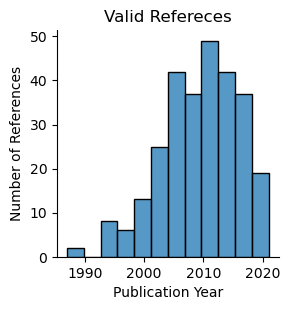

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.displot(
    data=number_of_references_df.loc[~number_of_references_df.DOI.isna()],
    x='Year_',
    height=3,
)
plt.title('Valid Refereces')
plt.ylabel('Number of References')
plt.xlabel('Publication Year')
plt.show()

In [69]:
number_of_references_df.DOI.value_counts()

DOI
https://doi.org/10.1371/journal.pgen.0030231          1
https://doi.org/10.1073/pnas.0403010101               1
https://doi.org/10.1073/pnas.0708608105               1
https://doi.org/10.1073/pnas.0807043105               1
https://doi.org/10.1073/pnas.1120312109               1
                                                     ..
https://doi.org/10.1261/rna.2509811                   1
https://doi.org/10.1261/rna.2670811                   1
https://doi.org/10.1371/journal.pgen.1002815          1
https://doi.org/10.1371/journal.pgen.1005571          1
https://doi.org/10.1002/j.1460-2075.1993.tb05652.x    1
Name: count, Length: 298, dtype: int64

In [70]:
number_of_references_df.head(2)['Example full reference'].unique()

array(['Kettler GC, et al. (2007) Patterns and Implications of Gene Gain and Loss in the Evolution of Prochlorococcus. PLoS Genetics, 3(12):e231.',
       'Dufresne, A., et al. (2003). Genome sequence of the cyanobacterium Prochlorococcus marinus SS120, a nearly minimal oxyphototrophic genome. PNAS, 100(17): 10020-10025.'],
      dtype=object)

# Uptake

In [111]:
uptake_series = df_database.loc[df_database.section_name.isin(['uptake']), 'section_content']


In [112]:
uptake_series.value_counts()

section_content
There is no direct evidence of AccB involvement in uptake processes in Prochlorococcus. However, its role in lipid biosynthesis indirectly affects membrane composition, which could influence cellular uptake capabilities[Schirmer et al., 2016].\n                         1
While purN is involved in de novo purine synthesis, Prochlorococcus has been shown to uptake external purine precursors and amino acids, potentially reducing the reliance on purN-mediated biosynthesis under certain conditions [Zubkov et al., 2015].\n                    1
There is no direct evidence of purH involvement in uptake processes in Prochlorococcus.\n                                                                                                                                                                                     1
There is no direct evidence of purF involvement in uptake processes. However, the presence of this gene for de novo purine synthesis suggests that Prochlorococcus can p

In [132]:
uptake_df = df_database.loc[
     df_database.section_name.isin(['uptake']) & 
     ~df_database.section_content.str.startswith('No direct evidence') & 
    ~df_database.section_content.str.startswith('No direct role') &
    ~df_database.section_content.str.startswith('No direct involvement in uptake processes') &
    ~df_database.section_content.str.startswith('No specific information available about uptake') &
    ~df_database.section_content.str.startswith('No specific data available on uptake processes') &
    ~df_database.section_content.str.startswith('No direct information available on uptake pro') &
    ~df_database.section_content.str.startswith('No direct information available about uptake') & 
    ~df_database.section_content.str.startswith('No specific data available regarding uptake')  &
    ~df_database.section_content.str.startswith('No specific information available for uptake') &
    ~df_database.section_content.str.startswith('Information not available for specific uptake processes') &
    ~df_database.section_content.str.startswith('No specific information available') &
    ~df_database.section_content.str.startswith('Insufficient data available on specific uptake processes') &
    ~df_database.section_content.str.startswith('Insufficient data available for specific uptake') &
    ~df_database.section_content.str.startswith('[No direct role in uptake processes identified]') &

    ~df_database.section_content.str.startswith('There is no direct evidence of ') &
    ~df_database.section_content.str.startswith('There is currently no direct evidence of the ') &
    ~df_database.section_content.str.startswith('There is no specific information available about the role of ') &
    ~df_database.section_content.str.startswith('There is currently no specific information available about the role of ') &
    ~df_database.section_content.str.startswith('No specific information is available about the role of ') &
    ~df_database.section_content.str.startswith('There is currently no direct evidence for ') &
    ~df_database.section_content.str.startswith('There is currently no direct evidence of ') &
    ~df_database.section_content.str.startswith('No specific information is available ') &
    ~df_database.section_content.str.startswith('There is currently no direct evidence linking ') &
    ~df_database.section_content.str.startswith('No direct information is available about ') &
    ~df_database.section_content.str.startswith('There is no direct evidence linking the ') &

    ~df_database.section_content.str.startswith('There is currently no available information on the role of ') &
    ~df_database.section_content.str.startswith('There is no specific information available about the involvement ') &
    ~df_database.section_content.str.startswith('There is no direct evidence linking the ') &

    ~df_database.section_content.str.startswith('There is currently no specific information ava') 
  
]
uptake_df

,gene,section_name,section_content,citations,Conservation
51,accD,uptake,While accD is not directly involved in uptake ...,,This indirect contribution to uptake processes...
74,acs,uptake,The acs gene product enables Prochlorococcus t...,"[Zubkov et al., 2003], [Bertilsson et al., 2003]",Acetate uptake capability appears to be conser...
145,amt,uptake,The AMT protein facilitates the high-affinity ...,"[Khademi et al., 2004], [Martiny et al., 2009]",The basic mechanism of ammonium uptake through...
453,arsB,uptake,While arsB is not directly involved in uptake ...,"[Saunders and Rocap, 2016]",This indirect influence on phosphate uptake is...
476,arsJ,uptake,"While ArsJ is primarily involved in efflux, th...",,This lack of uptake function appears to be con...
...,...,...,...,...,...
8175,urtD,uptake,UrtD is essential for the high-affinity uptake...,"[Kamennaya et al., 2008], [Biller et al., 2015]",This uptake process appears to be conserved ac...
8198,urtE,uptake,"UrtE is crucial for the uptake of urea, workin...","[Kamennaya & Post, 2013], [Scanlan et al., 2009]",The urea uptake process facilitated by the Urt...
8313,yidC,uptake,While not directly involved in uptake processe...,"[Kiefer and Kuhn, 2018]",This process is likely conserved across bacter...
8335,yidD,uptake,"As a membrane protein insertion factor, YidD m...",,The potential role in uptake processes is spec...


In [133]:
with pd.option_context('display.max_colwidth', None):
    display(uptake_df[['gene', 'section_content', 'Conservation', 'citations']].style.set_properties(**{'text-align': 'left'}))    

,gene,section_content,Conservation,citations
51,accD,"While accD is not directly involved in uptake processes, its role in fatty acid biosynthesis indirectly supports the maintenance of membrane integrity, which is crucial for various cellular uptake mechanisms.",This indirect contribution to uptake processes is likely conserved across Prochlorococcus strains.,
74,acs,"The acs gene product enables Prochlorococcus to take up and assimilate acetate from the environment [Zubkov et al., 2003]. This process may be particularly important in regions with elevated dissolved organic carbon concentrations.","Acetate uptake capability appears to be conserved across Prochlorococcus strains, but the efficiency and preference for acetate may vary [Bertilsson et al., 2003].","[Zubkov et al., 2003], [Bertilsson et al., 2003]"
145,amt,"The AMT protein facilitates the high-affinity uptake of ammonium (NH4+) across the cell membrane. It is capable of operating at very low external ammonium concentrations, typical of oligotrophic ocean environments. The transporter likely functions as a channel or carrier, potentially coupling ammonium transport with proton antiport [Khademi et al., 2004].","The basic mechanism of ammonium uptake through AMT proteins is conserved across Prochlorococcus strains and related organisms. However, kinetic properties and substrate affinities may vary slightly between different AMT paralogs and across strains [Martiny et al., 2009].","[Khademi et al., 2004], [Martiny et al., 2009]"
453,arsB,"While arsB is not directly involved in uptake processes, its presence may indirectly influence the uptake of phosphate. Arsenate, a structural analog of phosphate, can be accidentally taken up by phosphate transporters. The efficient efflux of arsenite by arsB may help maintain the cell's ability to continue phosphate uptake in arsenic-contaminated environments [Saunders and Rocap, 2016].","This indirect influence on phosphate uptake is likely conserved among arsB-containing Prochlorococcus strains, but the extent may vary depending on the efficiency of the arsB transporter and the overall arsenic resistance system.","[Saunders and Rocap, 2016]"
476,arsJ,"While ArsJ is primarily involved in efflux, there is no evidence of its involvement in arsenic uptake processes.",This lack of uptake function appears to be conserved across known Prochlorococcus strains.,
634,bioB,"While Prochlorococcus possesses bioB for biotin synthesis, it may also have the capability to uptake external biotin or its precursors. However, specific information on biotin uptake mechanisms in Prochlorococcus is limited.","The presence of biotin uptake mechanisms may vary among Prochlorococcus strains, but more research is needed to confirm this.",
657,carA,"While carA is not directly involved in nutrient uptake, its activity is closely linked to the cell's nitrogen assimilation processes. The enzyme uses glutamine as a substrate, which is derived from assimilated ammonium [Tolonen et al., 2006].","This process is likely conserved across Prochlorococcus strains due to the fundamental nature of nitrogen assimilation in these organisms [Biller et al., 2014].","[Tolonen et al., 2006], [Biller et al., 2014]"
751,ccsB,"CcsB, as part of the cytochrome c synthase complex, is likely involved in the uptake of heme into the periplasmic space for cytochrome c maturation [Frawley and Kranz, 2009].","This process is likely conserved across organisms using System II for cytochrome c biogenesis, including Prochlorococcus strains.","[Frawley and Kranz, 2009]"
774,cdaA,"There is no direct evidence for the involvement of cdaA in uptake processes in Prochlorococcus. However, given the role of c-di-AMP in regulating potassium uptake in other bacteria [Corrigan and Gründling, 2013], it may indirectly affect ion uptake.","The role in uptake processes, if any, is not well-established and its conservation is unclear.","[Corrigan and Gründling, 2013]"
843,chrA,"While chrA is not directly inv

In [134]:
uptake_df.shape

(118, 5)

# Exudation

In [135]:
exudation_series = df_database.loc[df_database.section_name.isin(['exudation']), 'section_content']


In [136]:
exudation_series.value_counts()

section_content
No specific information is available on AccB's role in exudation processes in Prochlorococcus.\n                                                                                                                                                                                                      1
There is limited direct evidence for purine exudation by Prochlorococcus. However, metabolic modeling and community interaction studies suggest that Prochlorococcus may release purine precursors or derivatives, potentially influencing microbial community dynamics [Biller et al., 2015].\n      1
Recent research suggests that Prochlorococcus may exude purine compounds, potentially involving the purH gene product[Zubkov et al., 2023].\n                                                                                                                                                         1
There is currently no available information on the role of purF or its products in exudation pro

In [143]:
exudation_df = df_database.loc[
    df_database.section_name.isin(['exudation']) & 
    ~df_database.section_content.str.startswith('No direct evidence') & 
    ~df_database.section_content.str.startswith('No direct role') &
    ~df_database.section_content.str.startswith('No known role') &
    ~df_database.section_content.str.startswith('No specific data available') &
    ~df_database.section_content.str.startswith('No specific information available') &
    ~df_database.section_content.str.startswith('No documented role') &
    ~df_database.section_content.str.startswith('No known exudation processes') &
    ~df_database.section_content.str.startswith('Insufficient data available regarding exudation processes') &
    ~df_database.section_content.str.startswith('No known direct role') &
    ~df_database.section_content.str.startswith('Insufficient data available') &
    ~df_database.section_content.str.startswith('No known direct role ') &
    ~df_database.section_content.str.startswith('Limited data available on ') &
    ~df_database.section_content.str.startswith('No documented exudation processes') &
    ~df_database.section_content.str.startswith('No documented') &
    ~df_database.section_content.str.startswith('No information available') &
    ~df_database.section_content.str.startswith('No information available regarding exudation processes') &
    ~df_database.section_content.str.startswith('No direct involvement in ') &
    ~df_database.section_content.str.startswith('No specific information available about') &
    ~df_database.section_content.str.startswith('No specific data available on') &
    ~df_database.section_content.str.startswith('No direct information available on') &
    ~df_database.section_content.str.startswith('No direct information available about') & 
    ~df_database.section_content.str.startswith('No specific data available regarding ')  &
    ~df_database.section_content.str.startswith('No specific information available for ') &
    ~df_database.section_content.str.startswith('Information not available for specific ') &
    ~df_database.section_content.str.startswith('No specific information available') &
    ~df_database.section_content.str.startswith('Insufficient data available on specific ') &
    ~df_database.section_content.str.startswith('Insufficient data available for specific') &

    ~df_database.section_content.str.startswith('No specific information is available ') &
    ~df_database.section_content.str.startswith('There is currently no direct evidence of ') &
    ~df_database.section_content.str.startswith('No information is available regarding the involvement of ') &
    ~df_database.section_content.str.startswith('No information is available regarding ') &
    ~df_database.section_content.str.startswith('There is no direct evidence of ') &



    ~df_database.section_content.str.startswith('[No direct role in exudation processes') 

  
]


In [144]:
exudation_df.shape

(191, 5)

In [145]:
with pd.option_context('display.max_colwidth', None):
    display(exudation_df[['gene', 'section_content']].style.set_properties(**{'text-align': 'left'}))

,gene,section_content
52,accD,"There is currently no direct evidence linking accD to exudation processes in Prochlorococcus. However, fatty acids or their derivatives produced via the acetyl-CoA carboxylase pathway might potentially be involved in signaling or interactions with other microorganisms."
146,amt,There is currently no direct evidence for AMT-mediated ammonium exudation in Prochlorococcus. The primary function appears to be uptake rather than export of ammonium.
339,aroA,"While aroA itself is not directly involved in exudation, the products of the shikimate pathway (aromatic amino acids) may be exuded by Prochlorococcus under certain conditions, potentially influencing microbial interactions in the marine environment [Biller et al., 2023]."
362,aroB,"While not directly linked to aroB, Prochlorococcus has been shown to exude various organic compounds, including amino acids[Aharonovich and Sher, 2016]. The products of the shikimate pathway, facilitated by aroB, may contribute to this exudation process."
385,aroC,"While not directly linked to aroC, some studies suggest that Prochlorococcus may exude certain metabolites, potentially including aromatic compounds, which could be involved in microbial interactions[Aharonovich and Sher, 2016]."
408,aroH,There is currently no available information on the role of aroH or its products in exudation processes in Prochlorococcus.
431,aroQ,"While not directly linked to aroQ, Prochlorococcus has been shown to exude organic compounds, potentially including aromatic compounds derived from the shikimate pathway[Zeng and Jiao, 2019]."
454,arsB,"arsB is directly responsible for the exudation of arsenite from Prochlorococcus cells. This efflux process is a critical component of the arsenic detoxification mechanism [Chen et al., 2019]."
477,arsJ,"ArsJ functions as an efflux transporter, actively extruding methylated arsenic compounds from the cell[Chen et al., 2019]. This exudation process is a key mechanism for arsenic detoxification in Prochlorococcus."
500,arsS,"While not directly studied in Prochlorococcus, arsenosugars produced by arsS could potentially be exuded into the environment, contributing to arsenic cycling in marine ecosystems."


# Stress response

In [146]:
stress_responses_series = df_database.loc[df_database.section_name.isin(['stress_responses']), 'section_content']


In [147]:
stress_responses_series.value_counts()


section_content
While specific data on accB-related stress responses in Prochlorococcus are limited, it is likely involved in the cellular response to nutrient limitation. Efficient lipid metabolism enabled by AccB may allow Prochlorococcus to adjust its membrane composition under nutrient stress[Partensky and Garczarek, 2010].\n                                      1
While specific stress responses related to psbM in Prochlorococcus are not well-documented, studies in other cyanobacteria suggest that PsbM may play a role in PSII repair and photoprotection under high light stress. The protein's involvement in PSII dimerization could be important for maintaining PSII stability under varying light conditions.\n      1
PsbN likely plays a role in the response to light stress by facilitating the repair and reassembly of photosystem II components damaged by high light intensity. This function is crucial for maintaining photosynthetic efficiency under varying light conditions [Zhan et al., 2

In [160]:
stress_responses_df = df_database.loc[
    df_database.section_name.isin(['stress_responses']) & 
    ~df_database.section_content.str.startswith('Limited data available') & 
    ~df_database.section_content.str.startswith('No direct studies available') & 
    ~df_database.section_content.str.startswith('No specific data available') & 
    ~df_database.section_content.str.startswith('Limited data available') & 
    ~df_database.section_content.str.startswith('Limited direct evidence') & 
    ~df_database.section_content.str.startswith('Limited direct evidence') & 
    ~df_database.section_content.str.startswith('Data not available') &
    ~df_database.section_content.str.startswith('Insufficient data available ') &
    ~df_database.section_content.str.startswith('Limited direct data available') &
    ~df_database.section_content.str.startswith('No direct experimental evidence') &
    ~df_database.section_content.str.startswith('No direct evidence') & 
    ~df_database.section_content.str.startswith('No specific stress response data available for') &
    ~df_database.section_content.str.startswith('Insufficient direct experimental data available') &
    ~df_database.section_content.str.startswith('Data on other stress responses is limited') &
    ~df_database.section_content.str.startswith('Data on specific stress responses is limited') &
    ~df_database.section_content.str.startswith('No direct studies on stress response roles for') &
    ~df_database.section_content.str.startswith('No direct experimental data available for') &
    ~df_database.section_content.str.startswith('[Information not available for additional stress responses]') &
 
    ~df_database.section_content.str.startswith('No documented direct involvement in other stress responses') &
    ~df_database.section_content.str.startswith('Data on other stress responses not available') &
    ~df_database.section_content.str.startswith('Data on specific stress responses is limited ') 
].copy()


In [161]:
for i in ['limitation', 'stress']:
    stress_responses_df[i] = stress_responses_df.section_content.str.extract(r'\b(\w+\s+' + i+')', flags=re.IGNORECASE)

In [162]:
remove_stresses = ['on stress',           
'of stress',
'in stress',
'during stress',
'Specific stress']
stress_responses_df.loc[stress_responses_df.stress.isin(remove_stresses), 'stress'] = np.NaN

In [163]:
for i in ['limitation', 'stress']:
    display(stress_responses_df[i].value_counts())


limitation
nutrient limitation      62
iron limitation          24
nitrogen limitation      18
phosphate limitation     12
phosphorus limitation     5
Nutrient limitation       3
sulfur limitation         3
B12 limitation            2
acid limitation           2
overcome limitation       1
cobalt limitation         1
light limitation          1
carbon limitation         1
Name: count, dtype: int64

stress
specific stress     109
oxidative stress     83
light stress         56
nutrient stress      51
nitrogen stress      22
                   ... 
such stress           1
salt stress           1
heat stress           1
sulfur stress         1
Light Stress          1
Name: count, Length: 65, dtype: int64

In [164]:
stress_responses_df['Stress/Limitation'] = stress_responses_df[['limitation', 'stress']].apply(lambda x: ', '.join(x.dropna()), axis=1)

In [165]:
#stress_responses_df[['Stress/Limitation']].value_counts(dropna=False).to_csv('stresses.csv')
stress_map = pd.read_csv('map_stress_values.csv')
stress_map

,Stress/Limitation,Stress,Stress Category
0,NaN,Unclear,Unclear
1,oxidative stress,Oxidative,Env
2,light stress,High-light,Env
3,temperature stress,Temperature,Thermal
4,nitrogen limitation,Nitrogen,Nutrients
...,...,...,...
66,membrane stress,Unclear,Unclear
67,copper limitation,Copper,Trace Metals
68,folate limitation,Folate,Vitamin
69,"iron limitation, under stress",Iron,Nutrients


In [158]:
stress_responses_df.columns, stress_map.columns

(Index(['gene', 'section_name', 'section_content', 'citations', 'Conservation',
        'limitation', 'stress', 'Stress/Limitation', 'Stress',
        'Stress Category'],
       dtype='object'),
 Index(['Stress/Limitation', 'Stress', 'Stress Category'], dtype='object'))

In [166]:
stress_responses_df = pd.merge(stress_responses_df, stress_map, on='Stress/Limitation', how='left')
#stress_responses_df['Stress'] = stress_responses_df['Stress'].fillna('Unclear')
#stress_responses_df['Stress Category'] = stress_responses_df['Stress Category'].fillna('Unclear')
stress_responses_df

,gene,section_name,section_content,citations,Conservation,limitation,stress,Stress/Limitation,Stress,Stress Category
0,accB,stress_responses,While specific data on accB-related stress res...,"[Partensky and Garczarek, 2010]",This response is likely conserved across Proch...,nutrient limitation,related stress,"nutrient limitation, related stress",NaN,NaN
1,accB,stress_responses,AccB may play a role in temperature stress res...,,The conservation of this response across Proch...,NaN,temperature stress,temperature stress,Temperature,Thermal
2,accC,stress_responses,accC expression may be modulated in response t...,"[Biller et al., 2014], [Zeng et al., 2021]",This response is likely conserved across Proch...,NaN,NaN,,NaN,NaN
3,accC,stress_responses,"Nutrient limitation, particularly phosphorus s...","[Partensky and Garczarek, 2010], [Kettler et a...","This response is likely conserved, but the ext...",Nutrient limitation,NaN,Nutrient limitation,Nutrient,Nutrients
4,accD,stress_responses,"Under nutrient limitation stress, Prochlorococ...","[Lauritano et al., 2019]",This response is likely conserved across Proch...,nutrient limitation,limitation stress,"nutrient limitation, limitation stress",Nutrient,Nutrients
...,...,...,...,...,...,...,...,...,...,...
720,ylqF,stress_responses,YlqF may play a role in temperature stress res...,,Temperature sensitivity of ribosome assembly i...,NaN,temperature stress,temperature stress,Temperature,Thermal
721,zds,stress_responses,High Light Stress: Under high light conditions...,"[Steglich et al., 2005], [Biller et al., 2015]",This high light stress response appears to be ...,NaN,Light Stress,Light Stress,NaN,NaN
722,zds,stress_responses,Oxidative Stress: The carotenoids produced thr...,"[Dufresne et al., 2003]",The role of zds in oxidative stress response i...,NaN,Oxidative Stress,Oxidative Stress,Oxidative,Env
723,zwf,stress_responses,The zwf gene plays a crucial role in oxidative...,"[Mella-Flores et al., 2012], [Mella-Flores et ...",This response appears to be conserved across P...,NaN,oxidative stress,oxidative stress,Oxidative,Env


In [167]:
stress_responses_df.shape, stress_responses_df.gene.nunique()

((725, 10), 363)

In [171]:
stress_responses_df['Stress/Limitation'].value_counts()

Stress/Limitation
                                       137
specific stress                         94
oxidative stress                        83
light stress                            56
nutrient stress                         29
                                      ... 
nutrient limitation, certain stress      1
antibiotic stress                        1
for stress                               1
cycle stress                             1
Light Stress                             1
Name: count, Length: 114, dtype: int64

In [172]:
stress_responses_df.groupby(['Stress Category', 'Stress'], dropna=False)['gene'].nunique(). reset_index()


,Stress Category,Stress,gene
0,Env,Environmental,12
1,Env,High-light,57
2,Env,Osmotic,13
3,Env,Oxidative,82
4,Env,UV,15
5,Nutrients,Iron,8
6,Nutrients,Nitrogen,28
7,Nutrients,Nutrient,61
8,Nutrients,Phosphate,6
9,Other,General,5


# Citations

In [193]:
df_database.loc[df_database.section_name.isin(['citations']), 'section_content'].value_counts().head(50)


section_content
https://eprints.soton.ac.uk/436684/1/Carter_Gates_Michael_PhD_Thesis_Dec_2019.pdf                                                                                     358
https://www.researchgate.net/publication/268987175_Prochlorococcus_The_structure_and_function_of_collective_diversity                                                 343
https://en.wikipedia.org/wiki/Prochlorococcus                                                                                                                         220
https://www.science.org/doi/10.1126/sciadv.adp1949                                                                                                                    212
https://website.whoi.edu/gfd/wp-content/uploads/sites/14/2018/10/2015Biller_NatRevMicro_263124.pdf                                                                    130
https://quizlet.com/713406685/microbiology-lecture-final-flash-cards/                                                                 

In [ ]:
citatio

# coculture

In [173]:
coculture_role_series = df_database.loc[df_database.section_name.isin(['coculture_role']), 'section_content']


In [174]:
coculture_role_series.value_counts()

section_content
Specific information about accB expression changes in Prochlorococcus when in coculture with heterotrophic bacteria is not available in the current literature.\n                                                                                                                                                                                                                                                                                                             1
In coculture conditions with heterotrophic bacteria, the expression of purN in Prochlorococcus may be influenced by metabolic interactions. Some studies suggest that the presence of heterotrophs might reduce the need for de novo purine synthesis in Prochlorococcus, potentially through the provision of purine precursors or other growth factors [Biller et al., 2015].\n                                                                                             1
While specific information about purH expression changes

In [175]:
coculture_role_df = df_database.loc[
    df_database.section_name.isin(['coculture_role']) & 
    ~df_database.section_content.str.startswith('Limited data available on expression changes in coculture conditions') & 
    ~df_database.section_content.str.startswith('Limited direct evidence ') &
    ~df_database.section_content.str.startswith('Insufficient data available ') &
    ~df_database.section_content.str.startswith('No specific data available') &
    ~df_database.section_content.str.startswith('No specific studies available ') &
    ~df_database.section_content.str.startswith('No direct studies available ') &
    ~df_database.section_content.str.startswith('No specific studies ') &
    ~df_database.section_content.str.startswith('No studies have directly examined ') &
    ~df_database.section_content.str.startswith('No significant changes ') &
    ~df_database.section_content.str.startswith('Limited data available on ') &
    ~df_database.section_content.str.startswith('Limited direct research on ') &
     ~df_database.section_content.str.startswith('Limited direct studies on ') &
     ~df_database.section_content.str.startswith('No direct evidence available') &
     ~df_database.section_content.str.startswith('No direct studies of ') &
     ~df_database.section_content.str.startswith('No specific information available ') &
     ~df_database.section_content.str.startswith('No studies available ') &
     ~df_database.section_content.str.startswith('No direct studies on ') &
     ~df_database.section_content.str.startswith('No published research available ') &
     ~df_database.section_content.str.startswith('No direct experimental evidence available ') &
     ~df_database.section_content.str.startswith('Limited direct studies available ') &
     ~df_database.section_content.str.startswith('Limited direct information available') &
     ~df_database.section_content.str.contains('not available in current literature')  &
     ~df_database.section_content.str.startswith('No direct evidence for specific role ') &
     ~df_database.section_content.str.startswith('[No specific information available ') 
    # ~df_database.section_content.str.startswith('No specific information available') &
    # ~df_database.section_content.str.startswith('Insufficient data available on specific ') &
    # ~df_database.section_content.str.startswith('Insufficient data available for specific') 

  
]


In [176]:
coculture_role_df.shape

(363, 5)

In [177]:
with pd.option_context('display.max_colwidth', None):
    display(coculture_role_df[['gene', 'section_content']].style.set_properties(**{'text-align': 'left'}))

,gene,section_content
7,accB,Specific information about accB expression changes in Prochlorococcus when in coculture with heterotrophic bacteria is not available in the current literature.
31,accC,"Specific information about accC expression changes in coculture conditions with heterotrophic bacteria is not available in the current literature. However, given its role in fatty acid biosynthesis, it may be involved in adjusting membrane composition in response to the presence of other microorganisms or their metabolites [Biller et al., 2014]."
54,accD,"While specific studies on accD expression in Prochlorococcus cocultures are limited, research on metabolic interactions between Prochlorococcus and heterotrophic bacteria suggests potential importance of fatty acid synthesis genes in these relationships [Biller et al., 2015]. Fatty acids or their derivatives produced via the acetyl-CoA carboxylase pathway might serve as signaling molecules or nutrients exchanged in the microbial community."
77,acs,"Specific information about the role of the acs gene in coculture conditions with heterotrophic bacteria is limited. However, given its role in acetate metabolism, it may be involved in the exchange of organic carbon between Prochlorococcus and heterotrophic bacteria [Morris et al., 2011]. Further research is needed to elucidate the specific changes in acs expression and function in coculture conditions."
102,acsF,"Specific information about the role of acsF in coculture conditions with heterotrophic bacteria is not available in the current literature. However, given its crucial role in chlorophyll biosynthesis, it is likely that acsF expression and function remain important in coculture conditions to maintain Prochlorococcus' photosynthetic capabilities."
125,alaS,Specific information about the role of alaS and its expression changes when Prochlorococcus is in coculture with heterotrophic bacteria is not available in the current literature.
148,amt,"Limited information is available on the specific role of amt gene expression changes in Prochlorococcus when in coculture with heterotrophic bacteria. However, studies on related cyanobacteria suggest that the presence of heterotrophs can influence nitrogen cycling and potentially affect ammonium availability in the microenvironment [Christie-Oleza et al., 2017]. This could indirectly influence amt gene expression and function in Prochlorococcus."
174,arfB,There is no direct information available about the role of arfB or its expression changes when Prochlorococcus is in coculture with heterotrophic bacteria.
195,argB,Specific information about argB's role and expression changes in coculture conditions with heterotrophic bacteria is not available in the current literature.
222,argC,"Specific information about argC gene expression or role changes in coculture conditions with heterotrophic bacteria is not available in the current literature. However, given the importance of arginine biosynthesis in nitrogen metabolism, it is possible that argC expression could be affected by the presence of heterotrophic bacteria that may compete for or provide nitrogen sources."


# Build gradio app

In [178]:
number_of_references_df.columns

Index(['First Author', 'Year', 'Title', 'Number_of_Genes', 'Example gene',
       'Example Authors', 'Example Journal', 'Example Pages',
       'Example full reference'],
      dtype='object')

In [179]:
number_of_references_df['Example Journal'].value_counts().to_dict()

{'Proceedings of the National Academy of Sciences': 49,
 'Journal of Biological Chemistry': 23,
 'Environmental Microbiology': 23,
 'Nature': 23,
 'The ISME Journal': 21,
 'PCC': 18,
 'Journal of Bacteriology': 18,
 'Frontiers in Microbiology': 18,
 'Science': 17,
 'Molecular Microbiology': 17,
 'Nature Reviews Microbiology': 17,
 'PLoS One': 15,
 'Nucleic Acids Research': 12,
 'Nature Microbiology': 10,
 'Limnology and Oceanography': 10,
 'Microbiology and Molecular Biology Reviews': 10,
 'ISME Journal': 10,
 'Science Advances': 9,
 'PloS one': 7,
 'Scientific Data': 6,
 'eLife': 6,
 'Applied and Environmental Microbiology': 6,
 'mSystems': 6,
 'FEMS Microbiology Letters': 5,
 'Life': 5,
 'The ISME journal': 5,
 'Microbiology': 4,
 'mBio': 4,
 'PLoS ONE': 4,
 'Journal of Phycology': 4,
 'Trends in Microbiology': 4,
 'MBio': 4,
 'Scientific Reports': 4,
 'Cell': 4,
 'Photosynthesis Research': 4,
 'Molecular Biology and Evolution': 4,
 'Biochimica et Biophysica Acta (BBA)-Bioenergetics'

In [180]:
reference_df.columns

Index(['gene', 'section_content', 'Authors', 'Year', 'Title', 'Journal_pages',
       'Journal', 'Pages', 'First Author', 'First Author lower',
       'Title lower'],
      dtype='object')

In [183]:
#c4e1ff
# stress_list
stress_list_of_stresses = [
    'Oxidative','High-light', 'Osmotic', 'Environmental', 'UV', 'Photooxidative', 'Salt', 'pH',
    'Nitrogen', 'Nutrient', 'Phosphate', 'Iron', 'Carbon', 'Sulfur', 'Phosphorus', 'CO2', 
    'Temperature', 'Cold', 'Heat', 
    'Metal', 'Arsenic', 'Cobalt', 'Copper', 'Selenium',
    'B12', 'Folate',
    'General', 'Unclear',
]
stress_categories = [ 'Env', 'Nutrients', 'Thermal', 'Trace Metals', 'Vitamin', 'Other','Unclear', ]
stress_color_list = [
    '#f7fcfd','#e5f5f9','#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824', # greens
    '#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#6e016b', # bupu
    '#fff7bc','#fec44f','#d95f0e', #ylorbr 
    '#feebe2','#fbb4b9','#f768a1','#c51b8a','#7a0177', # rdpu
    '#6a51a3','#4a1486', #purples
    '#cccccc','#969696', # greys
]
stress_color_map = dict(zip(stress_list_of_stresses, stress_color_list))
#sns.color_palette(stress_color_list)

In [186]:
database_cols_to_display = ['gene', 'section_content',  'Conservation', 'citations',]
reference_cols_to_display = ['Example full reference',  'Number_of_Genes', 'First Author', 'Year', 'Title','Example Journal', ]
reference_ungrouped_cols_to_display = ['gene', 'section_content',  'First Author', 'Year', 'Journal',    ]
df_to_display_genes = gff_named_df[['gene', 'product']]
df_to_display_coculture = coculture_role_df[database_cols_to_display]
df_to_display_exudation = exudation_df[database_cols_to_display]
df_to_display_uptake = uptake_df[database_cols_to_display]
df_to_display_stress = stress_responses_df[database_cols_to_display+ ['Stress Category', 'Stress', ]] 
df_to_display_reference = number_of_references_df[reference_cols_to_display].copy()
df_to_display_reference_ungrouped = reference_df[reference_ungrouped_cols_to_display].copy()
#df_to_display_reference['Number of Papers'] = 1
df_to_display_reference['Has DOI'] = 'No DOI'
df_to_display_reference_ungrouped['Has DOI'] = 'No DOI'
#df_to_display_reference['Has DOI'] = df_to_display_reference['DOI'].isna().map({True:'No DOI', False: 'Has DOI'})
#df_to_display_reference_ungrouped['Has DOI'] = df_to_display_reference_ungrouped['crossref DOI'].isna().map({True:'No DOI', False: 'Has DOI'})

In [187]:
import gradio as gr

df_to_display = gff_named_df[['gene', 'product']]
def filter_records(df, query):
    mask = np.column_stack([df[col].astype(str).str.contains(query, na=False, regex=False, case=False) for col in df])
    filtered_df = df.loc[mask.any(axis=1)]
    return filtered_df

def get_top_10(df, column, aggfunc):
    top_10_df = df.groupby(column)['Number_of_Genes'].agg('count').reset_index().nlargest(10, 'Number_of_Genes')
    return df.loc[df[column].isin(top_10_df[column])]
    
def filter_records_reference(df, query, hasdoi):
    hasdoi_map = {"All" : ['Has DOI', 'No DOI'], "Valid (with DOI)" : ['Has DOI'], "Invalid (no DOI)" : ['No DOI']}
    tmpdf = df.loc[df['Has DOI'].isin(hasdoi_map[hasdoi]) ]
    tmpdf = filter_records(tmpdf, query)
    return [tmpdf] * 2 + [get_top_10(tmpdf, 'First Author', 'count'), get_top_10(tmpdf, 'Example Journal', 'count')]

def filter_records_reference_ungrouped(df, query, hasdoi):
    hasdoi_map = {"All" : ['Has DOI', 'No DOI'], "Valid (with DOI)" : ['Has DOI'], "Invalid (no DOI)" : ['No DOI']}
    tmpdf = df.loc[df['Has DOI'].isin(hasdoi_map[hasdoi]) ]
    tmpdf = filter_records(tmpdf, query)
    return tmpdf

def filter_records_stress(df, query, categories):
    tmpdf = df.loc[df['Stress Category'].isin(categories) ]
    tmpdf = filter_records(tmpdf, query)
    return [tmpdf] * 2 


def gene_desc2text(gene):
    row_select = df_to_display.loc[df_to_display['gene'].isin([gene])].squeeze()
    return f'# {row_select["gene"]}:    {row_select["product"]}\n'

def on_select(evt: gr.SelectData):
    #  'col_value', 'index', 'row_value', 'selected', 'target', 'value']
    return evt.row_value[0]


In [188]:
gene_desc2text(gene)

'# dnaN:    DNA polymerase III subunit beta\n'

In [189]:
def get_gene_db_results(gene):
    desc = gene_desc2text(gene)
    
    literature_review, database_entry = parse_database_batch_message(gene)
    return desc, literature_review2text(literature_review), database_entry2text(database_entry)

In [190]:
with gr.Blocks(title='Perplexity Gene DB', ) as demo:

    ### Gene DB
    output_gene_desc = gr.Markdown()
    with gr.Row(equal_height=True):        
        with gr.Tab("Database Entry"):
            output_database_entry = gr.Markdown(label="Database Entry", container=True, show_label=True, show_copy_button=True)
        with gr.Tab("Literature Review"):
            output_lit_review = gr.Markdown(label="Literature Review", container=True, show_label=True, show_copy_button=True)
    with gr.Row():
        genename = gr.Textbox(label="Gene Name")
        genename.submit(fn=get_gene_db_results, inputs=genename, outputs=[output_gene_desc,output_lit_review, output_database_entry], api_name="Gene DB")
        submit_btn = gr.Button("Submit")
    examples = gr.Examples(
        examples=sorted(list(batch_result_dict.keys())), inputs=genename, examples_per_page=50)


    
    with gr.Accordion("Additional Info", open=True, ):

        # Gene Table
        with gr.Tab("List of Available Genes"):
            gene_filter_textbox =  gr.Textbox(label="Filter")
            
            gene_dataframe = gr.Dataframe(df_to_display_genes, max_height=700, wrap=True, )
            gene_dataframe.select(on_select, outputs=genename)
            gene_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_genes, x), inputs=gene_filter_textbox, outputs=gene_dataframe)

        
        # Coculture
        with gr.Tab("Role in Cucultures"):
            coculture_filter_textbox =  gr.Textbox(label="Filter")
            
            coculture_dataframe = gr.Dataframe(df_to_display_coculture, max_height=700, wrap=True,)
            coculture_dataframe.select(on_select, outputs=genename)
            coculture_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_coculture, x), inputs=coculture_filter_textbox, outputs=coculture_dataframe)


        # Uptake
        with gr.Tab("Uptake"):
            uptake_filter_textbox =  gr.Textbox(label="Filter")
            
            uptake_dataframe = gr.Dataframe(df_to_display_uptake, max_height=700, wrap=True,)
            uptake_dataframe.select(on_select, outputs=genename)
            uptake_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_uptake, x), inputs=uptake_filter_textbox, outputs=uptake_dataframe)


        #Exudation
        with gr.Tab("Exudation"):
            exudation_filter_textbox =  gr.Textbox(label="Filter")
            
            exudation_dataframe = gr.Dataframe(df_to_display_exudation, max_height=700, wrap=True,)
            exudation_dataframe.select(on_select, outputs=genename)
            exudation_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_exudation, x), inputs=exudation_filter_textbox, outputs=exudation_dataframe)


        # Stress
        with gr.Tab("Stress"):
            with gr.Row():
                stress_filter_textbox =  gr.Textbox(label="Filter")
                stress_category_select = gr.Dropdown(stress_categories, value=stress_categories, label="Stress Categories", multiselect=True)
            
            stress_plot = gr.BarPlot(
                df_to_display_stress, x="Stress Category", y="gene", 
                y_title="Number of Genes",  sort='y', color='Stress', y_aggregate="count", color_map=stress_color_map) 
            stress_dataframe = gr.Dataframe(df_to_display_stress, max_height=700, wrap=True,)
            stress_dataframe.select(on_select, outputs=genename)
            stress_filter_textbox.submit(fn=lambda x,y: filter_records_stress(df_to_display_stress, x,y), inputs=[stress_filter_textbox, stress_category_select], outputs=[stress_dataframe, stress_plot])
            stress_category_select.input(fn=lambda x,y: filter_records_stress(df_to_display_stress, x,y), inputs=[stress_filter_textbox, stress_category_select], outputs=[stress_dataframe, stress_plot])

            # stress_filter_textbox =  gr.Textbox(label="Filter")
            
            # stress_plot = gr.BarPlot(
            #     df_to_display_stress, x="Stress Category", y="gene", 
            #     y_title="Number of Genes",  sort='y', color='Stress', y_aggregate="count") 
            # stress_dataframe = gr.Dataframe(df_to_display_stress, max_height=700, wrap=True,)
            # stress_dataframe.select(on_select, outputs=genename)
            # stress_filter_textbox.submit(fn=lambda x: [filter_records(df_to_display_stress, x)] * 2, inputs=stress_filter_textbox, outputs=[stress_dataframe, stress_plot])


        # References
        with gr.Tab("References"):
            with gr.Row():
                reference_ungrouped_filter_textbox =  gr.Textbox(label="Filter")
                has_doi_ungrouped_select = gr.Dropdown(["All", "Valid (with DOI)", "Invalid (no DOI)"], value="All", label="Valid References")
            reference_ungrouped_dataframe = gr.Dataframe(df_to_display_reference_ungrouped, max_height=700, wrap=True,) # [reference_cols_to_display]
            #reference_dataframe.select(on_select, outputs=genename)
            reference_ungrouped_onselect_kwarg = dict(fn=lambda query, hasdoi: filter_records_reference_ungrouped(df_to_display_reference_ungrouped, query, hasdoi), inputs=[reference_ungrouped_filter_textbox, has_doi_ungrouped_select], outputs=[reference_ungrouped_dataframe])
            reference_ungrouped_filter_textbox.submit(**reference_ungrouped_onselect_kwarg)
            has_doi_ungrouped_select.input(**reference_ungrouped_onselect_kwarg)

        # References
        with gr.Tab("References Grouped"):
            with gr.Row():
                reference_filter_textbox =  gr.Textbox(label="Filter")
                has_doi_select = gr.Dropdown(["All", "Valid (with DOI)", "Invalid (no DOI)"], value="All", label="Valid References")
                stat_select = gr.Radio(["Number of citations", "Number of papers"], value="Number of papers", label="Summary Statistic")
            with gr.Row(equal_height=True):
                reference_all_by_year = gr.BarPlot(
                    df_to_display_reference, x="Year", y="Number_of_Genes", y_title="Number of Papers", color='Has DOI', x_bin=5, 
                    y_aggregate="count",
                    show_label=True, label='Publication Year', x_label_angle=30)
                reference_all_by_author = gr.BarPlot(
                    get_top_10(df_to_display_reference, 'First Author', 'count'), x="First Author", y="Number_of_Genes", 
                    y_title="Number of Papers", show_label=True, label='Top 10 Authors', sort='y', color='Has DOI', y_aggregate="count", x_label_angle=30) 
                reference_all_by_journal = gr.BarPlot(
                    get_top_10(df_to_display_reference, 'Example Journal', 'count'), x="Example Journal", y="Number_of_Genes", 
                    y_title="Number of Papers", show_label=True, label='Top 10 Journals', sort='y', color='Has DOI', y_aggregate="count", x_label_angle=30) 
                                                  
                
            reference_dataframe = gr.Dataframe(df_to_display_reference, max_height=700, wrap=True,) # [reference_cols_to_display]
            #reference_dataframe.select(on_select, outputs=genename)
            reference_filter_textbox.submit(fn=lambda query, hasdoi: filter_records_reference(df_to_display_reference, query, hasdoi), inputs=[reference_filter_textbox, has_doi_select], outputs=[reference_dataframe, reference_all_by_year,  reference_all_by_author, reference_all_by_journal])
            has_doi_select.input(fn=lambda query, hasdoi: filter_records_reference(df_to_display_reference, query, hasdoi), inputs=[reference_filter_textbox, has_doi_select], outputs=[reference_dataframe, reference_all_by_year,  reference_all_by_author, reference_all_by_journal])
            stat_select_map = {"Number of citations" : 'sum', "Number of papers" : 'count'}
            stat_select.change(lambda y: [gr.BarPlot(y_aggregate=stat_select_map[y], y_label=y)] * 3, stat_select, [reference_all_by_year,  reference_all_by_author, reference_all_by_journal])
    
    submit_btn.click(fn=get_gene_db_results, inputs=genename, outputs=[output_gene_desc,output_lit_review, output_database_entry], api_name="Gene DB")

#demo.launch(share=True)
demo.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
